In [1]:
from SkiModel import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp, simpson
import pymoo
import random
import pandas as pd

from Ski_Optimization_Simplified import *

In [2]:
#for setting color options
color_opts = ['black',"#98c98e", '#7fcdbb', "#15405d","#98c98e", '#7fcdbb', '#15405d']


Data import from sooth ski

In [3]:
def importData():
    file_path = "Sooth_ski_data_transpose.xlsx"
    df = pd.read_excel(file_path)
    df = df

    #print(df.columns)

    #get the relevant data
    data_Strings = ['Nominal Length (cm)', 'Waist Width (mm)', 'Tip Width (mm)', 'Sidecut Radius (m)', 'Sidecut Length (cm)']
    scale_factors = [100, 1000, 1000, 1, 100,1] #to get to m

    #print(data_Strings)
    #print(df[data_Strings])
    #print(df[data_Strings[4]].str.extract(r'([\d\.]+)'))
    df[data_Strings[4]] = df[data_Strings[4]].astype(str).str.extract(r'([\d\.]+)').astype(float)

    #print(df[data_Strings])


    #now calculate the approximate thickness
    EI = df['Average Bending Stiffness - EI (Nm²)']
    w = df['Tip Width (mm)']

    t = (EI/w/1000*12)**(1/3)/100 #m

    

    df['Thickness (m)'] = t

    data_Strings.append('Thickness (m)')

    #scale the data into an array
    datasubset = df[data_Strings]

    for i in range(0,len(data_Strings)):
        # print(scale_factors[i])
        # print(data_Strings[i])
        # print(datasubset[data_Strings[i]])
        datasubset[data_Strings[i]] = datasubset[data_Strings[i]]/scale_factors[i]
    
    numpy_data = datasubset.to_numpy()

    #print(datasubset)
    return numpy_data
    # print(data_Strings)
    # print(df[data_Strings[-1]])


Example Code for running 1 round of ski modeling to get efficiency and sensitivity measures

-1.0


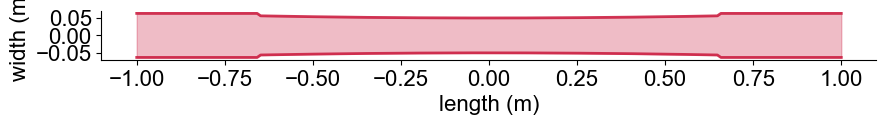

efficiency 5.65899579425141
R_con 17.269941774574743
Knee Torque 53.99302351773477


C:\Users\laSch\AppData\Local\Temp\ipykernel_27312\3225763690.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


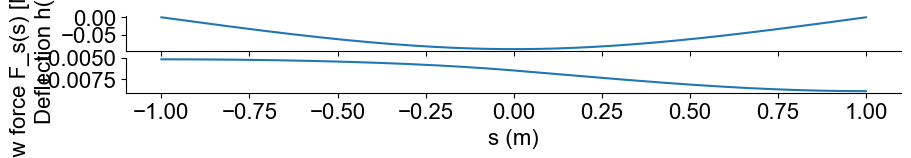

In [4]:
L = 2.0 #m, length of ski
w = 0.099 #m, waist width
w_max = .125 #m, max width
r_sc = 17.3 #m, sidecut radius
l_sc = 1.31 #length of sidecut
t_ski = .005 #thickness of ski


#trial run of full code
input_vector = [L,w,w_max, r_sc, l_sc, t_ski] #input optimize vector in this form

#visualize the ski 
s_vis = np.linspace(-2.0/2, 2.0/2, 200)
print(s_vis[0])
widths = get_widths(s_vis, L, w, w_max, r_sc, l_sc)
plot_ski(s_vis,widths)


#get the efficiency & sensitivity (it's a little sketch but at least it gives different numbers)
s,h, Fs, R_con, tau_knee, eff = ski_turn_iterative(input_vector, v_ski = 10) #can set weight and person length too if needed, current defaults: W_person=70, l_person=1.0
#print(f"Ft = {Ft:.2f} N,  Efficiency = {eff:.4f},  Sensitivity = {sens:.4e}")
print("efficiency", eff)
print("R_con", R_con)
print("Knee Torque", tau_knee)
#print(Fs)
plt.figure()
plt.subplot(2,1,1)
plt.plot(s, h); plt.ylabel("Deflection h(s) [m]")
plt.subplot(2,1,2)
plt.plot(s, Fs); plt.ylabel("Snow force F_s(s) [N/m]")
plt.xlabel("s (m)")
plt.tight_layout(); plt.show()

Code to make plots of 500 random skis 

c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: invalid value encountered in log10
  Efficiency = np.log10(-1/(F_f2/Fg))


(500, 9)


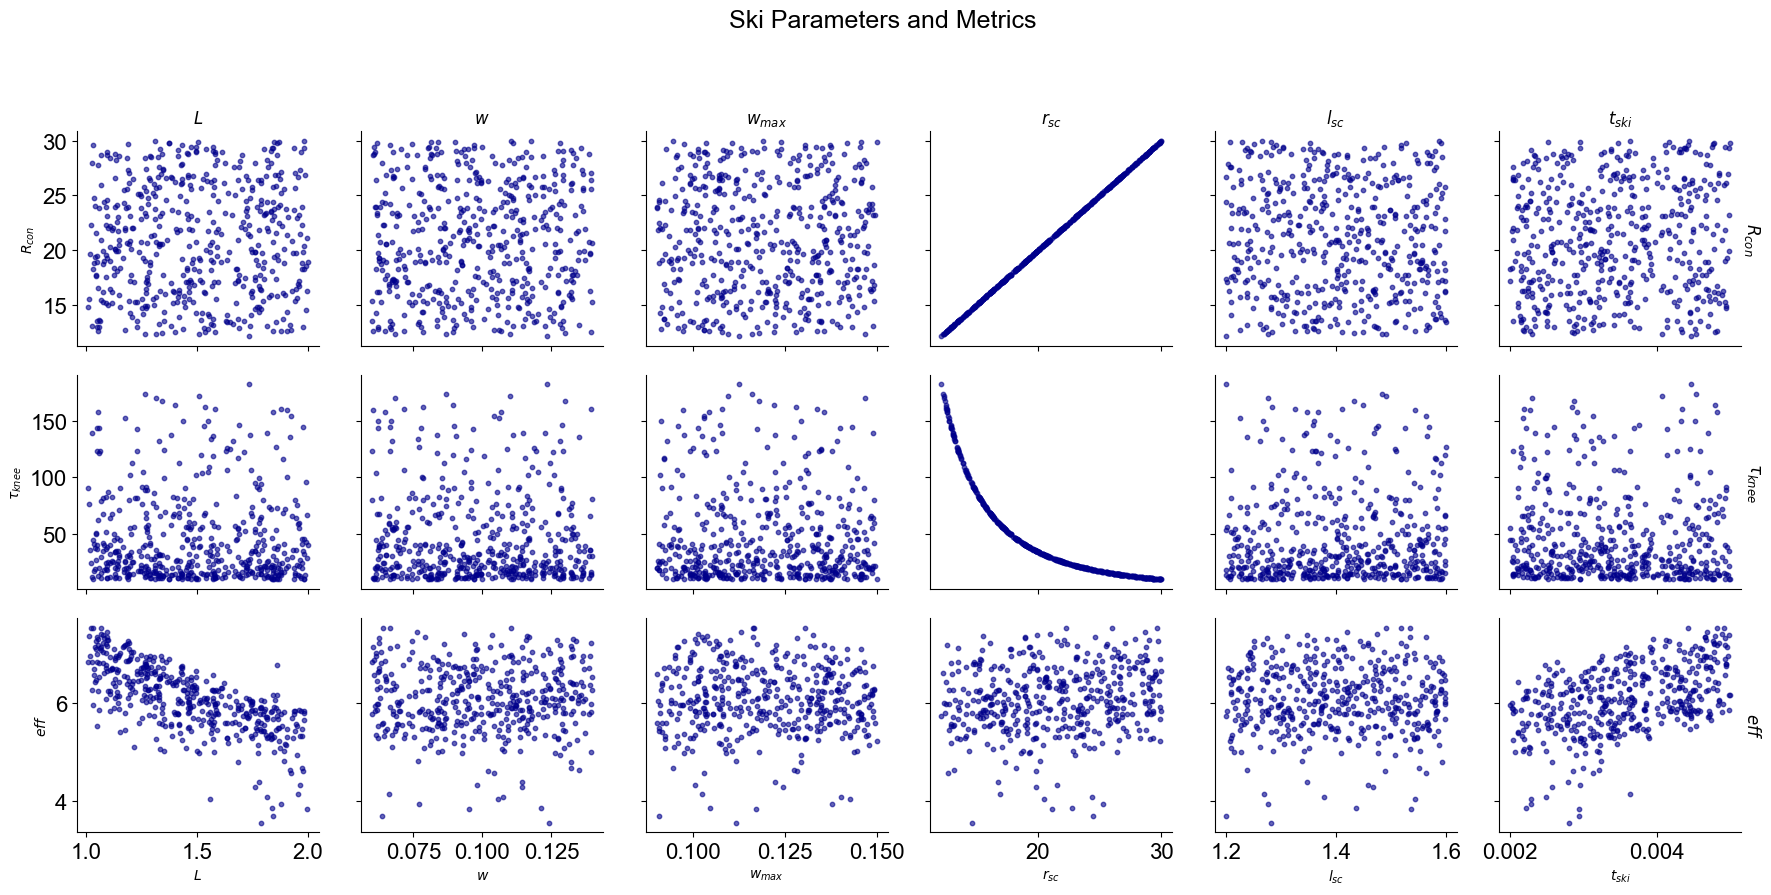

In [5]:
# ------ Code to make plots ------------

# L = 2.0 #m, length of ski
# w = 0.099 #m, waist width
# w_max = .125 #m, max width
# r_sc = 17.3 #m, sidecut radius
# l_sc = 1.31 #length of sidecut
# t_ski = .005 #thickness of ski
# np.random.seed(42)

Lbounds = [1,2]
wbounds = [0.06,0.14]
wmaxbounds = [.09,0.15]
r_scbounds = [12,30]
l_scbounds = [1.2,1.6]
t_skibounds = [0.002,0.005]

# print(np.random.uniform(Lbounds))

def gen_random_skis(N_samples):
    # generating random skis, and calculates metrics R_con, tau_knee, eff for all of them. 
    # returns np.array of size (N_samples, 9) where first 6 rows are the ski params, last 3 are the metrics

    N_samples = 500
    random_skis = []
    for i in range(N_samples):
        skivec = [np.random.uniform(*Lbounds), np.random.uniform(*wbounds), np.random.uniform(*wmaxbounds),np.random.uniform(*r_scbounds),np.random.uniform(*l_scbounds),np.random.uniform(*t_skibounds)]
        random_skis.append(skivec)

    random_skis = np.array(random_skis)

    # print('randomly generated skis', random_skis)
    #calculating metrics for all of the random skis
    skimetrics = []

    for ski in random_skis:
        s,h, Fs, R_con, tau_knee, eff = ski_turn_iterative(ski, v_ski = 10)
        metr = [R_con,tau_knee,eff]

        skimetrics.append(metr)

    ski_metrics = np.array(skimetrics)

    skis_and_metrics = np.concatenate((random_skis,ski_metrics),axis=1)
    print(skis_and_metrics.shape)

    return skis_and_metrics

# format of each vector is [L,w,wmax,r_sc,l_sc,t_ski,R_con,tau_knee,eff]

skis_and_metrics = gen_random_skis(500)
# # def plot_relationships(skis_and_metrics):
# L = [ski[0] for ski in skis_and_metrics]
# w = [ski[1] for ski in skis_and_metrics]
# wmax = [ski[2] for ski in skis_and_metrics]
# r_sc = [ski[3] for ski in skis_and_metrics]
# l_sc =  [ski[4] for ski in skis_and_metrics]
# t_ski = [ski[5] for ski in skis_and_metrics]
# R_con = [ski[6] for ski in skis_and_metrics]
# tau_knee = [ski[7] for ski in skis_and_metrics]
# eff = [ski[8] for ski in skis_and_metrics]

# plt.title('Length and tau_knee')
# plt.xlabel('Ski length')
# plt.ylabel('Tau_knee')
# plt.scatter(L,tau_knee)
import numpy as np
import matplotlib.pyplot as plt

# --- DATA ASSUMPTION ---
# The (500, 9) array 'skis_and_metrics' is assumed to be defined here.
# (Assuming your array is already loaded or defined elsewhere in your environment)
# -------------------------


# Define the column names
param_names = [r'$L$', r'$w$', r'$w_{max}$', r'$r_{sc}$', r'$l_{sc}$', r'$t_{ski}$']
metric_names = [r'$R_{con}$', r'$\tau_{knee}$', r'$eff$']

N_metrics = len(metric_names)   # 3 rows (for Y-axis metrics)
N_params = len(param_names)     # 6 columns (for X-axis parameters)

# --- 1. CREATE SUBPLOTS ---
# Create a figure with 3 rows (Metrics) and 6 columns (Parameters)
fig, axes = plt.subplots(N_metrics, N_params, figsize=(18, 9), sharex='col', sharey='row')
fig.suptitle('Ski Parameters and Metrics ', fontsize=18, y=1.03)

# --- 2. GENERATE PLOTS IN A NESTED LOOP ---
# row_idx: Metric index (0 to 2) -> defines the Y-axis data
# col_idx: Parameter index (0 to 5) -> defines the X-axis data

for row_idx in range(N_metrics):
    for col_idx in range(N_params):
        
        # Metric index in the (500, 9) array starts at 6
        m_idx_data = 6 + row_idx  # Used for Y-Axis data (Metric)
        p_idx_data = col_idx      # Used for X-Axis data (Parameter)
        
        # Select the correct Axes object: axes[row, column]
        ax = axes[row_idx, col_idx]
        
        # X-Axis Data: Parameter (columns 0-5)
        X_data = skis_and_metrics[:, p_idx_data] 
        # Y-Axis Data: Metric (columns 6-8)
        Y_data = skis_and_metrics[:, m_idx_data] 
        
        # Create the Scatter Plot
        ax.scatter(X_data, Y_data, s=10, alpha=0.6, color='darkblue')
        
        # --- Labeling Logic ---
        
        # X-Axis Labels (Parameter name): Only set for the bottom row (row_idx == N_metrics - 1)
        if row_idx == N_metrics - 1:
            ax.set_xlabel(param_names[col_idx], fontsize=10) # Use the Parameter name for X-label
        
        # Y-Axis Labels (Metric name): Only set for the first column (col_idx == 0)
        if col_idx == 0:
            ax.set_ylabel(metric_names[row_idx], fontsize=10) # Use the Metric name for Y-label
        
        # Column Titles: Add Parameter name as a title (for the top row)
        if row_idx == 0:
            ax.set_title(param_names[col_idx], fontsize=12)

        # Row Labels: Add Metric name as a label on the right side of the figure
        if col_idx == N_params - 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(metric_names[row_idx], rotation=270, labelpad=15, fontsize=12)


# --- 3. FINAL LAYOUT ADJUSTMENTS ---
# Adjust spacing between subplots
fig.tight_layout(rect=[0, 0.03, 1, 1.00]) 



NSGA-II without regularization

Starting PyMOO (NSGA-II) Multi-Objective Optimization for 100 generations...


c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:195: RuntimeWarning: invalid value encountered in arcsin
  phi = np.arcsin(v_ski**2/g/r_sc)


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      150 |    150 |             - |             -
     2 |      300 |    150 |  1.194416E-06 |             f
     3 |      450 |    150 |  3.562665E-06 |             f
     4 |      600 |    150 |  5.343937E-06 |             f
     5 |      750 |    150 |  7.053254E-06 |             f
     6 |      900 |    150 |  9.680689E-06 |             f
     7 |     1050 |    150 |  0.0000113222 |             f
     8 |     1200 |    150 |  0.0000105633 |             f
     9 |     1350 |    150 |  0.0000116581 |             f
    10 |     1500 |    150 |  0.0000117291 |             f
    11 |     1650 |    150 |  0.0000116091 |             f
    12 |     1800 |    150 |  0.0000115089 |             f
    13 |     1950 |    150 |  0.0000116962 |             f
    14 |     2100 |    150 |  0.0000111899 |             f
    15 |     2250 |    150 |  0.0000121358 |             f
    16 |     2400 |    150 |  0.0000128419 |            

c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  Efficiency = np.log10(-1/(F_f2/Fg))


    32 |     4800 |    150 |  0.0000143582 |             f
    33 |     4950 |    150 |  0.0000153786 |             f
    34 |     5100 |    150 |  0.0000150018 |             f
    35 |     5250 |    150 |  0.0000151915 |             f
    36 |     5400 |    150 |  0.0000140926 |             f
    37 |     5550 |    150 |  0.0000142216 |             f
    38 |     5700 |    150 |  0.0000134827 |             f
    39 |     5850 |    150 |  0.0000142681 |             f
    40 |     6000 |    150 |  0.0000149977 |             f
    41 |     6150 |    150 |  0.0000139731 |             f
    42 |     6300 |    150 |  0.0000145291 |             f
    43 |     6450 |    150 |  0.0000136343 |             f
    44 |     6600 |    150 |  0.0000144177 |             f
    45 |     6750 |    150 |  0.0000145532 |             f
    46 |     6900 |    150 |  0.0000140642 |             f
    47 |     7050 |    150 |  0.0000136913 |             f
    48 |     7200 |    150 |  0.0000135995 |            

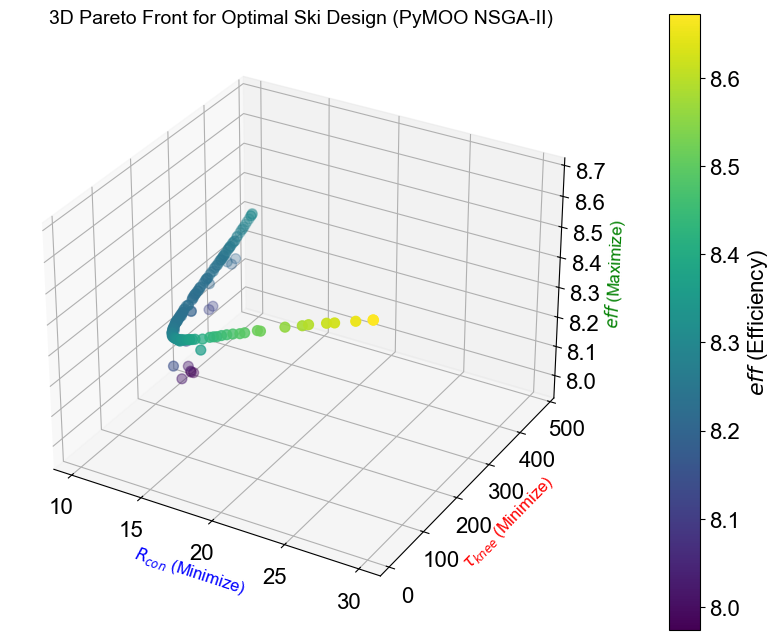

[1.00000320e+00 1.05886635e-01 9.82848820e-02 1.01938119e+01
 1.38105175e+00 9.99987869e-03]


<Figure size 1000x100 with 0 Axes>

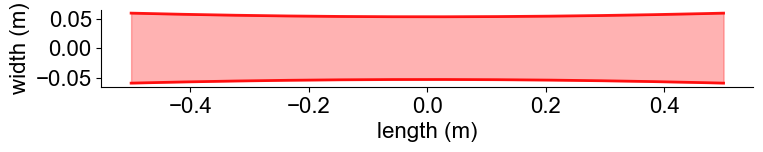

[1.00023128e+00 1.25131915e-01 1.39934179e-01 2.99998138e+01
 1.24594323e+00 9.99989291e-03]


<Figure size 1000x100 with 0 Axes>

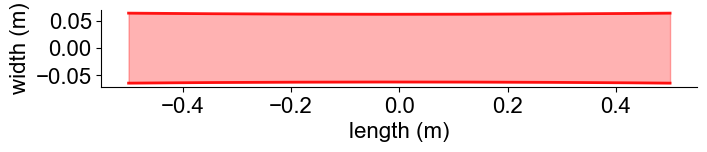

[1.10308225e+00 1.34996902e-01 1.20544411e-01 1.10678639e+01
 1.28300426e+00 9.99973319e-03]


<Figure size 1000x100 with 0 Axes>

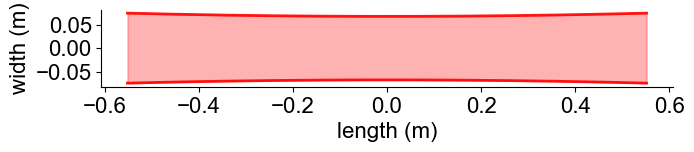

<Figure size 1000x100 with 0 Axes>

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- 0. Problem Definition ---

# Define parameter bounds
Lbounds = [1.0, 2.0]
wbounds = [0.06, 0.14]
wmaxbounds = [0.09, 0.15]
r_scbounds = [8.0, 30.0]
l_scbounds = [1.2, 1.6]
t_skibounds = [0.002, 0.01]

PENALTY_VALUE = 1e6 # Penalty for failed simulation

class SkiDesignProblem(Problem):
    def __init__(self):
        # n_var: 6 design variables
        # n_obj: 3 objectives
        # xl: lower bounds
        # xu: upper bounds
        super().__init__(
            n_var=6,
            n_obj=3,
            n_constr=0,
            xl=np.array([Lbounds[0], wbounds[0], wmaxbounds[0], r_scbounds[0], l_scbounds[0], t_skibounds[0]]),
            xu=np.array([Lbounds[1], wbounds[1], wmaxbounds[1], r_scbounds[1], l_scbounds[1], t_skibounds[1]])
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # X is the array of designs to evaluate. Each row is one ski design.
        
        # Initialize objective arrays
        f1 = np.full(X.shape[0], PENALTY_VALUE)  # R_con (Minimize)
        f2 = np.full(X.shape[0], PENALTY_VALUE)  # tau_knee (Minimize)
        f3 = np.full(X.shape[0], -PENALTY_VALUE) # eff (Maximize: store as negative for pymoo's minimization engine)
        
        for i, parameters in enumerate(X):
            L, w, w_max, r_sc, l_sc, t_ski = parameters
            ski_vec = [L, w, w_max, r_sc, l_sc, t_ski]
            
            try:
                # ASSUME ski_turn_iterative returns: s, h, Fs, R_con, tau_knee, eff
                results = ski_turn_iterative(ski_vec, v_ski=10)
                R_con_val = results[3]
                tau_knee_val = results[4]
                eff_val = results[5]

                # Check for NaN/Inf
                if not all(np.isfinite([R_con_val, tau_knee_val, eff_val])):
                    continue # Skip this trial, penalties remain

                f1[i] = R_con_val
                f2[i] = tau_knee_val
                # PyMOO always MINIMIZES. To MAXIMIZE 'eff', we minimize -eff.
                f3[i] = -eff_val 

            except Exception:
                # Skip this trial, penalties remain
                continue

        # Set the output arrays for PyMOO
        out["F"] = np.column_stack([f1, f2, f3])


# --- 2. Run the Optimization (NSGA-II) ---

N_GENERATIONS = 100
POPULATION_SIZE = 150

print(f"Starting PyMOO (NSGA-II) Multi-Objective Optimization for {N_GENERATIONS} generations...")

problem = SkiDesignProblem()

# Define the NSGA-II algorithm configuration
algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15), # Simulated Binary Crossover
    mutation=PM(prob=1/6, eta=20),  # Polynomial Mutation
    eliminate_duplicates=True
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GENERATIONS),
    seed=1,
    verbose=True
)

print("\n--- Optimization Complete ---")

# --- 3. Analyze and Visualize the Pareto Front ---

# Extract the non-dominated solutions (the Pareto Front)
pareto_solutions_F = res.F
pareto_solutions_X = res.X
mask = -pareto_solutions_F[:,2] < 20
pareto_solutions_F = pareto_solutions_F[mask]
pareto_solutions_X = pareto_solutions_X[mask]
pareto_solutions = pareto_solutions_F

if pareto_solutions is None or pareto_solutions.size == 0:
    print("Error: No non-dominated solutions found.")
else:
    # Separate the objective values
    pareto_r_con = pareto_solutions[:, 0]
    pareto_tau_knee = pareto_solutions[:, 1]
    
    # Remember, PyMOO minimized -eff, so we must negate it back to get the true efficiency
    pareto_eff = -pareto_solutions[:, 2] 

    print(f"Found {len(pareto_r_con)} non-dominated solutions on the Pareto Front.")
    
    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d') 
    
    # Scatter plot the Pareto solutions
    scatter = ax.scatter(pareto_r_con, pareto_tau_knee, pareto_eff, 
                         c=pareto_eff, cmap='viridis', s=50)

    # Label the axes
    ax.set_xlabel(r'$R_{con}$ (Minimize)', fontsize=12, color='blue')
    ax.set_ylabel(r'$\tau_{knee}$ (Minimize)', fontsize=12, color='red')
    ax.set_zlabel(r'$eff$ (Maximize)', fontsize=12, color='green')
    ax.set_title('3D Pareto Front for Optimal Ski Design (PyMOO NSGA-II)', fontsize=14)

    # Add a color bar for the efficiency (eff) objective
    cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
    cbar.set_label(r'$eff$ (Efficiency)')
    
    plt.show()

PlotName = "NSGAII-ParetoFront"
plt.savefig("Figures/" + PlotName + ".png", dpi=300)

#add the skis generated and save the plots
PlotName = "NSGAII-kneetorqueSki"
loc = pareto_solutions_F[:,1] == max(pareto_solutions_F[:,1])
vec = pareto_solutions_X[loc]
vec = vec[0]
print(vec)
plot_ski_from_vector(vec, 'red', PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "NSGAII-RcurveSki"
loc = pareto_solutions_F[:,0] == max(pareto_solutions_F[:,0])
vec = pareto_solutions_X[loc]
vec = vec[0]
print(vec)
plot_ski_from_vector(vec, 'red', PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "NSGAII-efficiencySki"
loc = pareto_solutions_F[:,2] == max(pareto_solutions_F[:,2])
vec = pareto_solutions_X[loc]
vec = vec[0]
print(vec)
plot_ski_from_vector(vec, 'red', PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

NSGA-II with data driven regularization

In [7]:
import numpy as np
from scipy.integrate import solve_bvp, simpson
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- PyMOO Imports ---
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2 # Using NSGA-II as requested
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize

# --- 0. Global Definitions and Historical Data ---

PENALTY_VALUE = 1e6 

# Define the bounds (used for search space and for normalization)
XL = np.array([1.0, 0.06, 0.09, 8.0, 1.2, 0.002]) # L, w, w_max, r_sc, l_sc, t_ski (Lower Bounds)
XU = np.array([2.0, 0.14, 0.15, 30.0, 1.6, 0.01])  # Upper Bounds
RANGE = XU - XL

# Example Historical/Successful Ski Designs (N_designs x 6)
# Each row is a design: [L, w, w_max, r_sc, l_sc, t_ski]
HISTORICAL_DATA = np.array([
    [1.95, 0.095, 0.12, 18.0, 1.35, 0.0045], # Design 1
    [1.80, 0.110, 0.13, 16.5, 1.25, 0.0050], # Design 2
    [2.00, 0.090, 0.11, 20.0, 1.40, 0.0035], # Design 3
    [1.75, 0.085, 0.125, 15.0, 1.30, 0.0065]  # Design 4
])

realskis = importData()
DATA_NORM = (realskis - XL) / RANGE # Normalized Historical Data (calculated once)

def calculate_regularization_objective(X):
    """
    Calculates the minimum normalized Euclidean distance from the current design X
    to the HISTORICAL_DATA set. This is the 4th objective f4, which is MINIMIZED.
    """
    # Normalize the current design vector X
    X_norm = (X - XL) / RANGE

    # Calculate the difference (broadcasting over all historical designs)
    diff = X_norm - DATA_NORM 
    
    # Calculate the distance: sqrt(sum(diff^2))
    dist_squared = np.sum(diff**2, axis=1)

    # The objective f4 is the minimum distance (closest match)
    return np.min(np.sqrt(dist_squared))

# --- 2. PyMOO Problem Definition (4 Objectives) ---

class SkiDesignProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=6,
            n_obj=4, # <--- 4 objectives: R_con, tau_knee, eff, Regularization
            n_constr=0,
            xl=XL, # Use global bounds
            xu=XU
        )

    def _evaluate(self, X, out, *args, **kwargs):
        # f1: R_con (Min), f2: tau_knee (Min), f3: -eff (Min), f4: distance (Min)
        f1 = np.full(X.shape[0], PENALTY_VALUE)
        f2 = np.full(X.shape[0], PENALTY_VALUE)
        f3 = np.full(X.shape[0], -PENALTY_VALUE)
        f4 = np.full(X.shape[0], PENALTY_VALUE) # Initialize distance high
        
        for i, parameters in enumerate(X):
            try:
                # --- Objective Calculation ---
                results = ski_turn_iterative(parameters, v_ski=10)
                R_con_val = results[3]
                tau_knee_val = results[4]
                eff_val = results[5]

                if not all(np.isfinite([R_con_val, tau_knee_val, eff_val])):
                    continue 

                f1[i] = R_con_val
                f2[i] = tau_knee_val
                f3[i] = -eff_val # Minimize -eff (Maximize eff)

                # --- Regularization Objective (f4) ---
                f4[i] = calculate_regularization_objective(parameters)

            except Exception:
                continue

        # Set the output arrays for PyMOO (4 columns)
        out["F"] = np.column_stack([f1, f2, f3, f4])


# --- 3. Run the Optimization (NSGA-II) ---

N_GENERATIONS = 250 
POPULATION_SIZE = 50 

print(f"Starting PyMOO (NSGA-II) Multi-Objective Optimization with Data Regularization for {N_GENERATIONS} generations...")

problem = SkiDesignProblem()

randskis = gen_random_skis(50)

algorithm = NSGA2(
    pop_size=POPULATION_SIZE,
    sampling= randskis[:,0:6],
    crossover=SBX(prob=0.9, eta=10), 
    mutation=PM(prob=1/6, eta=15),  
    eliminate_duplicates=True
)

# Run the optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GENERATIONS),
    seed=1,
    verbose=False
)

print("\n--- Optimization Complete ---")


C:\Users\laSch\AppData\Local\Temp\ipykernel_27312\3969229274.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasubset[data_Strings[i]] = datasubset[data_Strings[i]]/scale_factors[i]
c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: invalid value encountered in log10
  Efficiency = np.log10(-1/(F_f2/Fg))
c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:195: RuntimeWarning: invalid value encountered in arcsin
  phi = np.arcsin(v_ski**2/g/r_sc)


Starting PyMOO (NSGA-II) Multi-Objective Optimization with Data Regularization for 250 generations...
(500, 9)


c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: divide by zero encountered in scalar divide
  Efficiency = np.log10(-1/(F_f2/Fg))



--- Optimization Complete ---


In [8]:
# a = pareto_solutions_F
# print(a.shape)
# mask = -a[:,2] <10
# b = a[mask]
# print(b.shape)
# print(max(-a[:,2]))

res.F [[ 1.05965980e+01  3.26998930e+02 -2.49717555e+00  2.17638507e-01]
 [ 1.08593557e+01  2.88738455e+02 -5.73147209e+00  2.78974276e-02]
 [ 1.00000000e+06  1.00000000e+06 -1.00000000e+06  1.00000000e+06]
 [ 1.00000000e+06  1.00000000e+06 -1.00000000e+06  1.00000000e+06]
 [ 2.99826762e+01  9.62931999e+00 -7.54599410e+00  9.70037833e-01]
 [ 1.01425919e+01  4.80068102e+02 -7.05113340e+00  5.84827377e-01]
 [ 2.99796603e+01  9.63228598e+00 -8.64608214e+00  1.27387637e+00]
 [ 2.99807530e+01  9.63121125e+00 -8.67352813e+00  1.23592236e+00]
 [ 2.99826762e+01  9.62931999e+00 -5.96639194e+00  4.29695299e-01]
 [ 1.01425919e+01  4.80068102e+02 -6.12127609e+00  2.87607976e-01]
 [ 1.32703622e+01  1.30749281e+02 -7.14824682e+00  9.06567080e-01]
 [ 1.47289847e+01  9.12254151e+01 -5.23328753e+00  1.17736841e-01]
 [ 1.66501337e+01  6.07905110e+01 -8.34910983e+00  1.10562476e+00]
 [ 1.24166462e+01  1.66430427e+02 -6.30574044e+00  4.70940407e-01]
 [ 1.02866057e+01  3.94981543e+02 -5.93832390e+00  2.877

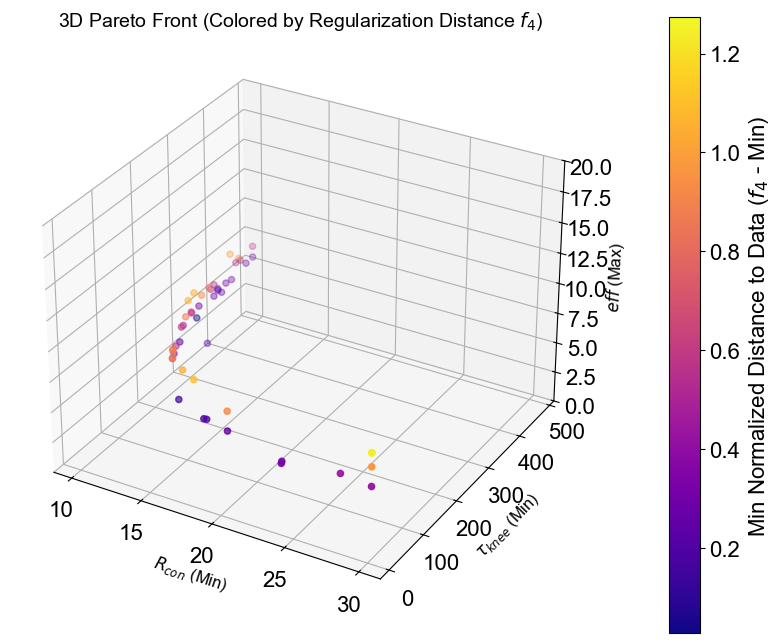

[1.00291157e+00 9.86539352e-02 1.23631177e-01 1.01936884e+01
 1.37348717e+00 3.83852645e-03]


<Figure size 1000x100 with 0 Axes>

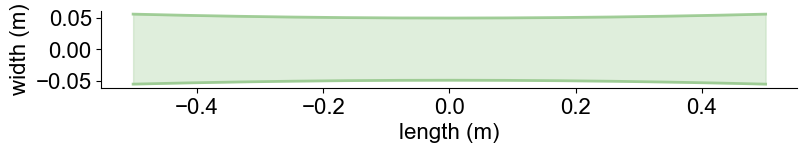

[1.51799714e+00 9.90193763e-02 1.20424365e-01 2.99999998e+01
 1.37659178e+00 9.69788036e-03]


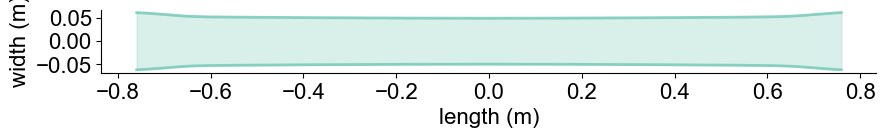

[1.51238065e+00 9.90977626e-02 1.25488203e-01 1.06455155e+01
 1.36084364e+00 2.54779519e-03]


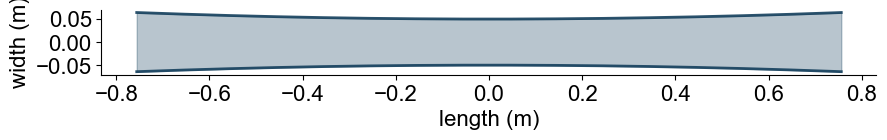

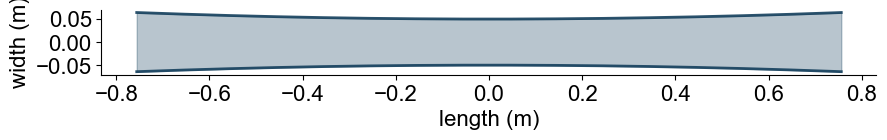

In [ ]:

# --- 4. Analyze Results (Modified) ---

# res.X holds all the design vectors (parameters) from the final population
# res.F holds all the objective values from the final population
pareto_solutions_F = res.F
pareto_solutions_X = res.X # <--- Get the design parameters
mask = -pareto_solutions_F[:,2] < 20
pareto_solutions_F = pareto_solutions_F[mask]
pareto_solutions_X = pareto_solutions_X[mask]

print('res.F',res.F)
print('res.X',res.X)

if pareto_solutions_F is None or pareto_solutions_F.size == 0:
    print("Error: No non-dominated solutions found.")
else:
    # Separate the objective values (same as before)
    pareto_r_con = pareto_solutions_F[:, 0]
    pareto_tau_knee = pareto_solutions_F[:, 1]
    pareto_eff = -pareto_solutions_F[:, 2] 
    pareto_distance = pareto_solutions_F[:, 3] 

    print(f"Found {len(pareto_solutions_F)} non-dominated solutions on the 4-Objective Pareto Front.")

    # --- Print Example Solutions with Parameters ---
    print("\n--- Top 5 Optimized Ski Designs from the Pareto Front ---")
    
    # We will print the top solutions based on their index in the res.F/res.X arrays.
    for i in range(min(5, len(pareto_solutions_F))):
        
        # Extract the design vector for the i-th non-dominated solution
        L, w, w_max, r_sc, l_sc, t_ski = pareto_solutions_X[i] 
        
        print(f"**SKI DESIGN {i+1}:**")
        
        # Print Design Parameters
        print(f"  **Parameters:**")
        print(f"    Length (L): {L:.3f} m")
        print(f"    Waist Width (w): {w*1000:.1f} mm") # Convert to mm
        print(f"    Max Width (w_max): {w_max*1000:.1f} mm") # Convert to mm
        print(f"    Sidecut Radius (r_sc): {r_sc:.1f} m")
        print(f"    Sidecut Length (l_sc): {l_sc:.2f} m")
        print(f"    Thickness (t_ski): {t_ski*1000:.2f} mm") # Convert to mm
        
        # Print Objective Values
        print(f"  **Objectives:**")
        print(f"    R_con (Min): {pareto_r_con[i]:.3f} m")
        print(f"    Tau_knee (Min): {pareto_tau_knee[i]:.3f} N·m")
        print(f"    Efficiency (Max): {pareto_eff[i]:.3f} (Log10)")
        print(f"    Reg. Distance (Min): {pareto_distance[i]:.4f} (Normalized)")
        print("-" * 35)

    # --- Example 3D Visualization (Same as before) ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d') 
    
    scatter = ax.scatter(pareto_r_con, pareto_tau_knee, pareto_eff, 
                         c=pareto_distance, cmap='plasma')

    # 1. R_con (X-axis): Minimize. Example: Set range from 10 to 35
    #ax.set_xlim([10.0, 35.0]) 
    
    # 2. tau_knee (Y-axis): Minimize. Example: Set range from 50 to 100
    #ax.set_ylim([50.0, 100.0]) 
    
    # 3. eff (Z-axis): Maximize. Example: Set range from 0.7 to 1.0 (True efficiency)
    ax.set_zlim([0, 20])

    ax.set_xlabel(r'$R_{con}$ (Min)', fontsize=12, color='black')
    ax.set_ylabel(r'$\tau_{knee}$ (Min)', fontsize=12, color='black')
    ax.set_zlabel(r'$eff$ (Max)', fontsize=12, color='black')
    ax.set_title('3D Pareto Front (Colored by Regularization Distance $f_4$)', fontsize=14)

    fig.colorbar(scatter, ax=ax, pad=0.1).set_label(r'Min Normalized Distance to Data ($f_4$ - Min)')
    

PlotName = "NSGAII_reg-ParetoFront"
plt.savefig("Figures/" + PlotName + ".png", dpi=300)
plt.show()

#add the skis generated and save the plots
PlotName = "NSGAII_reg-kneetorqueSki"
loc = pareto_solutions_F[:,1] == max(pareto_solutions_F[:,1])
vec = pareto_solutions_X[loc]
vec = vec[0]
nsga_knee_vec = vec
print(vec)
plot_ski_from_vector(vec, color_opts[-3], PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "NSGAII_reg-RcurveSki"
loc = pareto_solutions_F[:,0] == max(pareto_solutions_F[:,0])
vec = pareto_solutions_X[loc]
vec = vec[0]
nsga_rcon_vec = vec
print(vec)
plot_ski_from_vector(vec, color_opts[-2], PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "NSGAII_reg-efficiencySki"
loc = pareto_solutions_F[:,2] == max(pareto_solutions_F[:,2])
vec = pareto_solutions_X[loc]
vec = vec[0]
nsga_eff_vec = vec
print(vec)
plot_ski_from_vector(vec, color_opts[-1], PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)


Bayesian single scalarized objective with sciopt

Starting Multi-Objective Bayesian Optimization (skopt) for 50 trials...

--- Optimization Complete ---
Minimum Scalarized Objective Value Found: 1.6202

Best Ski Parameters Found:
  L: 1.0000
  w: 0.0600
  w_max: 0.0900
  r_sc: 12.0000
  l_sc: 1.6000
  t_ski: 0.0100

Metrics for Optimal Design:
  R_con (Target: Min): 11.957
  Tau_knee (Target: Min): 192.102
  Eff (Target: Max): 8.243
[1.0, 0.06, 0.09, 12.0, 1.6, 0.01]


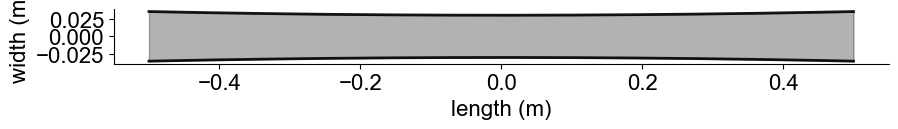

In [10]:
# Bayesian single scalarized objective with sciopt - all metrics

import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# --- 0. Setup and Helper Function ---

# Define parameter bounds (6 parameters)
Lbounds = [1.0, 2.0]        # L (Length)
wbounds = [0.06, 0.14]      # w (Waist Width)
wmaxbounds = [0.09, 0.15]   # w_max (Max Width)
r_scbounds = [12.0, 30.0]    # r_sc (Sidecut Radius)
l_scbounds = [1.2, 1.6]     # l_sc (Sidecut Length)
t_skibounds = [0.002, 0.01] # t_ski (Thickness)

# Weights for Scalarization (Adjust these weights based on metric importance/scale)
# For simplicity, we use equal weights here, but you should scale them 
# if your metrics have vastly different magnitudes (e.g., R_con=15m vs tau_knee=50Nm).
ALPHA = 1.0  # Weight for R_con (Minimize)
BETA = 1.0   # Weight for tau_knee (Minimize)
GAMMA = 1.0  # Weight for eff (Maximize)

# 1. Define the Search Space (Dimensions) for skopt
dimensions = [
    Real(*Lbounds, name='L'),
    Real(*wbounds, name='w'),
    Real(*wmaxbounds, name='w_max'),
    Real(*r_scbounds, name='r_sc'),
    Real(*l_scbounds, name='l_sc'),
    Real(*t_skibounds, name='t_ski'),
]

@use_named_args(dimensions=dimensions)
def objective(L, w, w_max, r_sc, l_sc, t_ski):
    """
    skopt objective function: must return a single value to be MINIMIZED.
    """
    
    # 2. Prepare ski vector and call simulation function
    ski_vec = [L, w, w_max, r_sc, l_sc, t_ski]
    
    # ASSUME ski_turn_iterative returns: s, h, Fs, R_con, tau_knee, eff
    try:
        results = ski_turn_iterative(ski_vec, v_ski=1)
        R_con_val = results[3]   # Metric 1: Minimize
        tau_knee_val = results[4] # Metric 2: Minimize
        eff_val = results[5]      # Metric 3: Maximize
    except Exception as e:
        # Return a large positive value if simulation fails, guiding skopt away
        print(f"Ski evaluation failed: {e}. Returning large penalty.")
        return 1e10 
        
    # 3. Scalarize the Objectives
    # We MINIMIZE: (ALPHA * MIN_METRIC_1) + (BETA * MIN_METRIC_2) - (GAMMA * MAX_METRIC_3)
    scalarized_objective = (ALPHA * R_con_val) + (BETA * tau_knee_val) - (GAMMA * eff_val)

    return scalarized_objective

# --- 2. Run Optimization ---

N_CALLS = 50 # Total number of function evaluations

print(f"Starting Multi-Objective Bayesian Optimization (skopt) for {N_CALLS} trials...")

res_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=N_CALLS,
    n_random_starts=10,  # Explore 10 random points first
    random_state=42,
    acq_func="EI"        # Expected Improvement is standard for minimization
)

# --- 3. Analyze Results ---

# The best result is stored in res_gp.x (parameters) and res_gp.fun (minimized objective value)
best_params_list = res_gp.x

# Convert the best parameter list back into a named dictionary
best_params = {name.name: value for name, value in zip(dimensions, best_params_list)}

# To get the individual metrics for the best point, we must call the simulation function again
ski_vec_best = [best_params['L'], best_params['w'], best_params['w_max'], 
                best_params['r_sc'], best_params['l_sc'], best_params['t_ski']]
results_best = ski_turn_iterative(ski_vec_best, v_ski=10)
R_con_best = results_best[3]
tau_knee_best = results_best[4]
eff_best = results_best[5]

print("\n--- Optimization Complete ---")
print(f"Minimum Scalarized Objective Value Found: {res_gp.fun:.4f}")
print("\nBest Ski Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print("\nMetrics for Optimal Design:")
print(f"  R_con (Target: Min): {R_con_best:.3f}")
print(f"  Tau_knee (Target: Min): {tau_knee_best:.3f}")
print(f"  Eff (Target: Max): {eff_best:.3f}")

PlotName = "Skopt_all_metrics_Ski"
vec = ski_vec_best
print(vec)
plot_ski_from_vector(vec, color_opts[0], PlotName = PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

skopt_all_vec = ski_vec_best


Starting Multi-Objective Bayesian Optimization (skopt) for 50 trials...

--- Optimization Complete ---
Minimum Scalarized Objective Value Found: -0.0000

Best Ski Parameters Found:
  L: 1.4763
  w: 0.0758
  w_max: 0.1379
  r_sc: 14.7451
  l_sc: 1.3782
  t_ski: 0.0056

Metrics for Optimal Design:
  R_con (Target: Min): 14.710
  Tau_knee (Target: Min): 91.627
  Eff (Target: Max): 6.547
[1.4762602341210198, 0.07578927720214733, 0.13788210464916373, 14.745124082938448, 1.3781983243595088, 0.005606493677154665]


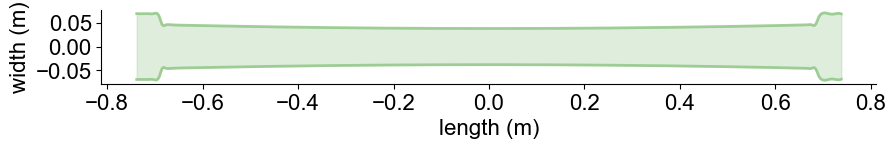

In [11]:
# Bayesian single scalarized objective with sciopt - knee tau

import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# --- 0. Setup and Helper Function ---

# Define parameter bounds (6 parameters)
Lbounds = [1.0, 2.0]        # L (Length)
wbounds = [0.06, 0.14]      # w (Waist Width)
wmaxbounds = [0.09, 0.15]   # w_max (Max Width)
r_scbounds = [12.0, 30.0]    # r_sc (Sidecut Radius)
l_scbounds = [1.2, 1.6]     # l_sc (Sidecut Length)
t_skibounds = [0.002, 0.01] # t_ski (Thickness)

# Weights for Scalarization (Adjust these weights based on metric importance/scale)
# For simplicity, we use equal weights here, but you should scale them 
# if your metrics have vastly different magnitudes (e.g., R_con=15m vs tau_knee=50Nm).
ALPHA = 0.0  # Weight for R_con (Minimize)
BETA = 1.0   # Weight for tau_knee (Minimize)
GAMMA = 0.0  # Weight for eff (Maximize)

# 1. Define the Search Space (Dimensions) for skopt
dimensions = [
    Real(*Lbounds, name='L'),
    Real(*wbounds, name='w'),
    Real(*wmaxbounds, name='w_max'),
    Real(*r_scbounds, name='r_sc'),
    Real(*l_scbounds, name='l_sc'),
    Real(*t_skibounds, name='t_ski'),
]

@use_named_args(dimensions=dimensions)
def objective(L, w, w_max, r_sc, l_sc, t_ski):
    """
    skopt objective function: must return a single value to be MINIMIZED.
    """
    
    # 2. Prepare ski vector and call simulation function
    ski_vec = [L, w, w_max, r_sc, l_sc, t_ski]
    
    # ASSUME ski_turn_iterative returns: s, h, Fs, R_con, tau_knee, eff
    try:
        results = ski_turn_iterative(ski_vec, v_ski=1)
        R_con_val = results[3]   # Metric 1: Minimize
        tau_knee_val = results[4] # Metric 2: Minimize
        eff_val = results[5]      # Metric 3: Maximize
    except Exception as e:
        # Return a large positive value if simulation fails, guiding skopt away
        print(f"Ski evaluation failed: {e}. Returning large penalty.")
        return 1e10 
        
    # 3. Scalarize the Objectives
    # We MINIMIZE: (ALPHA * MIN_METRIC_1) + (BETA * MIN_METRIC_2) - (GAMMA * MAX_METRIC_3)
    scalarized_objective = (ALPHA * R_con_val) + (BETA * tau_knee_val) - (GAMMA * eff_val)

    return scalarized_objective

# --- 2. Run Optimization ---

N_CALLS = 50 # Total number of function evaluations

print(f"Starting Multi-Objective Bayesian Optimization (skopt) for {N_CALLS} trials...")

res_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=N_CALLS,
    n_random_starts=10,  # Explore 10 random points first
    random_state=42,
    acq_func="EI"        # Expected Improvement is standard for minimization
)

# --- 3. Analyze Results ---

# The best result is stored in res_gp.x (parameters) and res_gp.fun (minimized objective value)
best_params_list = res_gp.x

# Convert the best parameter list back into a named dictionary
best_params = {name.name: value for name, value in zip(dimensions, best_params_list)}

# To get the individual metrics for the best point, we must call the simulation function again
ski_vec_best = [best_params['L'], best_params['w'], best_params['w_max'], 
                best_params['r_sc'], best_params['l_sc'], best_params['t_ski']]
results_best = ski_turn_iterative(ski_vec_best, v_ski=10)
R_con_best = results_best[3]
tau_knee_best = results_best[4]
eff_best = results_best[5]

print("\n--- Optimization Complete ---")
print(f"Minimum Scalarized Objective Value Found: {res_gp.fun:.4f}")
print("\nBest Ski Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print("\nMetrics for Optimal Design:")
print(f"  R_con (Target: Min): {R_con_best:.3f}")
print(f"  Tau_knee (Target: Min): {tau_knee_best:.3f}")
print(f"  Eff (Target: Max): {eff_best:.3f}")

PlotName = "Skopt_kneetau_Ski"
vec = ski_vec_best
print(vec)
plot_ski_from_vector(vec, color_opts[1], PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

skopt_kneetau_vec = ski_vec_best


Starting Multi-Objective Bayesian Optimization (skopt) for 50 trials...


c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1.0, 0.06, 0.09, 12.0, 1.2, 0.01] before, using random point [1.668949073732414, 0.06578354251835741, 0.09795530230448066, 21.784559000941375, 1.2133033058316478, 0.00254299287742244]
  warnings.warn(
c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\.venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2.0, 0.14, 0.09, 12.0, 1.2, 0.01] before, using random point [1.0966661846554226, 0.09153400165873984, 0.09970582932750754, 17.60480520496011, 1.5021050594143783, 0.004758905866903659]
  warnings.warn(
c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: invalid value encountered in log10
  Efficiency = np.log10(-1/(F_f2/Fg))



--- Optimization Complete ---
Minimum Scalarized Objective Value Found: 11.9996

Best Ski Parameters Found:
  L: 1.0000
  w: 0.0600
  w_max: 0.0900
  r_sc: 12.0000
  l_sc: 1.6000
  t_ski: 0.0020

Metrics for Optimal Design:
  R_con (Target: Min): 11.957
  Tau_knee (Target: Min): 192.102
  Eff (Target: Max): nan
[1.0, 0.06, 0.09, 12.0, 1.6, 0.002]


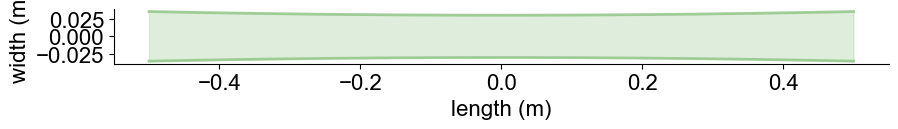

In [12]:
# Bayesian single scalarized objective with sciopt - r_con

import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# --- 0. Setup and Helper Function ---

# Define parameter bounds (6 parameters)
Lbounds = [1.0, 2.0]        # L (Length)
wbounds = [0.06, 0.14]      # w (Waist Width)
wmaxbounds = [0.09, 0.15]   # w_max (Max Width)
r_scbounds = [12.0, 30.0]    # r_sc (Sidecut Radius)
l_scbounds = [1.2, 1.6]     # l_sc (Sidecut Length)
t_skibounds = [0.002, 0.01] # t_ski (Thickness)

# Weights for Scalarization (Adjust these weights based on metric importance/scale)
# For simplicity, we use equal weights here, but you should scale them 
# if your metrics have vastly different magnitudes (e.g., R_con=15m vs tau_knee=50Nm).
ALPHA = 1.0  # Weight for R_con (Minimize)
BETA = 0.0   # Weight for tau_knee (Minimize)
GAMMA = 0.0  # Weight for eff (Maximize)

# 1. Define the Search Space (Dimensions) for skopt
dimensions = [
    Real(*Lbounds, name='L'),
    Real(*wbounds, name='w'),
    Real(*wmaxbounds, name='w_max'),
    Real(*r_scbounds, name='r_sc'),
    Real(*l_scbounds, name='l_sc'),
    Real(*t_skibounds, name='t_ski'),
]

@use_named_args(dimensions=dimensions)
def objective(L, w, w_max, r_sc, l_sc, t_ski):
    """
    skopt objective function: must return a single value to be MINIMIZED.
    """
    
    # 2. Prepare ski vector and call simulation function
    ski_vec = [L, w, w_max, r_sc, l_sc, t_ski]
    
    # ASSUME ski_turn_iterative returns: s, h, Fs, R_con, tau_knee, eff
    try:
        results = ski_turn_iterative(ski_vec, v_ski=1)
        R_con_val = results[3]   # Metric 1: Minimize
        tau_knee_val = results[4] # Metric 2: Minimize
        eff_val = results[5]      # Metric 3: Maximize
    except Exception as e:
        # Return a large positive value if simulation fails, guiding skopt away
        print(f"Ski evaluation failed: {e}. Returning large penalty.")
        return 1e10 
        
    # 3. Scalarize the Objectives
    # We MINIMIZE: (ALPHA * MIN_METRIC_1) + (BETA * MIN_METRIC_2) - (GAMMA * MAX_METRIC_3)
    scalarized_objective = (ALPHA * R_con_val) + (BETA * tau_knee_val) - (GAMMA * eff_val)

    return scalarized_objective

# --- 2. Run Optimization ---

N_CALLS = 50 # Total number of function evaluations

print(f"Starting Multi-Objective Bayesian Optimization (skopt) for {N_CALLS} trials...")

res_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=N_CALLS,
    n_random_starts=10,  # Explore 10 random points first
    random_state=42,
    acq_func="EI"        # Expected Improvement is standard for minimization
)

# --- 3. Analyze Results ---

# The best result is stored in res_gp.x (parameters) and res_gp.fun (minimized objective value)
best_params_list = res_gp.x

# Convert the best parameter list back into a named dictionary
best_params = {name.name: value for name, value in zip(dimensions, best_params_list)}

# To get the individual metrics for the best point, we must call the simulation function again
ski_vec_best = [best_params['L'], best_params['w'], best_params['w_max'], 
                best_params['r_sc'], best_params['l_sc'], best_params['t_ski']]
results_best = ski_turn_iterative(ski_vec_best, v_ski=10)
R_con_best = results_best[3]
tau_knee_best = results_best[4]
eff_best = results_best[5]

print("\n--- Optimization Complete ---")
print(f"Minimum Scalarized Objective Value Found: {res_gp.fun:.4f}")
print("\nBest Ski Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print("\nMetrics for Optimal Design:")
print(f"  R_con (Target: Min): {R_con_best:.3f}")
print(f"  Tau_knee (Target: Min): {tau_knee_best:.3f}")
print(f"  Eff (Target: Max): {eff_best:.3f}")

PlotName = "Skopt_R_con_Ski"
vec = ski_vec_best
print(vec)
plot_ski_from_vector(vec, color_opts[1], PlotName)
#plt.savefig("Figures/" + PlotName + ".png", dpi=300)

skopt_rcon_vec = ski_vec_best


Starting Multi-Objective Bayesian Optimization (skopt) for 50 trials...

--- Optimization Complete ---
Minimum Scalarized Objective Value Found: -10.7795

Best Ski Parameters Found:
  L: 1.0000
  w: 0.0600
  w_max: 0.0900
  r_sc: 30.0000
  l_sc: 1.6000
  t_ski: 0.0100

Metrics for Optimal Design:
  R_con (Target: Min): 29.983
  Tau_knee (Target: Min): 9.629
  Eff (Target: Max): 8.674
[1.0, 0.06, 0.09, 30.0, 1.6, 0.01]


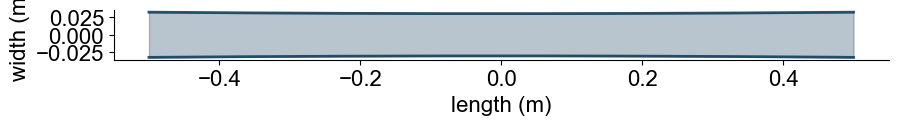

In [13]:
# Bayesian single scalarized objective with sciopt - eff

import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# --- 0. Setup and Helper Function ---

# Define parameter bounds (6 parameters)
Lbounds = [1.0, 2.0]        # L (Length)
wbounds = [0.06, 0.14]      # w (Waist Width)
wmaxbounds = [0.09, 0.15]   # w_max (Max Width)
r_scbounds = [12.0, 30.0]    # r_sc (Sidecut Radius)
l_scbounds = [1.2, 1.6]     # l_sc (Sidecut Length)
t_skibounds = [0.002, 0.01] # t_ski (Thickness)

# Weights for Scalarization (Adjust these weights based on metric importance/scale)
# For simplicity, we use equal weights here, but you should scale them 
# if your metrics have vastly different magnitudes (e.g., R_con=15m vs tau_knee=50Nm).
ALPHA = 0.0  # Weight for R_con (Minimize)
BETA = 0.0   # Weight for tau_knee (Minimize)
GAMMA = 1.0  # Weight for eff (Maximize)

# 1. Define the Search Space (Dimensions) for skopt
dimensions = [
    Real(*Lbounds, name='L'),
    Real(*wbounds, name='w'),
    Real(*wmaxbounds, name='w_max'),
    Real(*r_scbounds, name='r_sc'),
    Real(*l_scbounds, name='l_sc'),
    Real(*t_skibounds, name='t_ski'),
]

@use_named_args(dimensions=dimensions)
def objective(L, w, w_max, r_sc, l_sc, t_ski):
    """
    skopt objective function: must return a single value to be MINIMIZED.
    """
    
    # 2. Prepare ski vector and call simulation function
    ski_vec = [L, w, w_max, r_sc, l_sc, t_ski]
    
    # ASSUME ski_turn_iterative returns: s, h, Fs, R_con, tau_knee, eff
    try:
        results = ski_turn_iterative(ski_vec, v_ski=1)
        R_con_val = results[3]   # Metric 1: Minimize
        tau_knee_val = results[4] # Metric 2: Minimize
        eff_val = results[5]      # Metric 3: Maximize
    except Exception as e:
        # Return a large positive value if simulation fails, guiding skopt away
        print(f"Ski evaluation failed: {e}. Returning large penalty.")
        return 1e10 
        
    # 3. Scalarize the Objectives
    # We MINIMIZE: (ALPHA * MIN_METRIC_1) + (BETA * MIN_METRIC_2) - (GAMMA * MAX_METRIC_3)
    scalarized_objective = (ALPHA * R_con_val) + (BETA * tau_knee_val) - (GAMMA * eff_val)

    return scalarized_objective

# --- 2. Run Optimization ---

N_CALLS = 50 # Total number of function evaluations

print(f"Starting Multi-Objective Bayesian Optimization (skopt) for {N_CALLS} trials...")

res_gp = gp_minimize(
    func=objective,
    dimensions=dimensions,
    n_calls=N_CALLS,
    n_random_starts=10,  # Explore 10 random points first
    random_state=42,
    acq_func="EI"        # Expected Improvement is standard for minimization
)

# --- 3. Analyze Results ---

# The best result is stored in res_gp.x (parameters) and res_gp.fun (minimized objective value)
best_params_list = res_gp.x

# Convert the best parameter list back into a named dictionary
best_params = {name.name: value for name, value in zip(dimensions, best_params_list)}

# To get the individual metrics for the best point, we must call the simulation function again
ski_vec_best = [best_params['L'], best_params['w'], best_params['w_max'], 
                best_params['r_sc'], best_params['l_sc'], best_params['t_ski']]
results_best = ski_turn_iterative(ski_vec_best, v_ski=10)
R_con_best = results_best[3]
tau_knee_best = results_best[4]
eff_best = results_best[5]

print("\n--- Optimization Complete ---")
print(f"Minimum Scalarized Objective Value Found: {res_gp.fun:.4f}")
print("\nBest Ski Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print("\nMetrics for Optimal Design:")
print(f"  R_con (Target: Min): {R_con_best:.3f}")
print(f"  Tau_knee (Target: Min): {tau_knee_best:.3f}")
print(f"  Eff (Target: Max): {eff_best:.3f}")

PlotName = "Skopt_efficiency_Ski"
vec = ski_vec_best
print(vec)
px = plot_ski_from_vector(vec, color_opts[3], PlotName)
#px.savefig("Figures/" + PlotName + ".png", dpi=300)

skopt_eff_vec = ski_vec_best


Final Comparison Code and Plotting

c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: invalid value encountered in log10
  Efficiency = np.log10(-1/(F_f2/Fg))
C:\Users\laSch\AppData\Local\Temp\ipykernel_27312\3969229274.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasubset[data_Strings[i]] = datasubset[data_Strings[i]]/scale_factors[i]


Data shape (features x samples): (195, 6)
Explained variance ratio: [0.99678629 0.00271862]


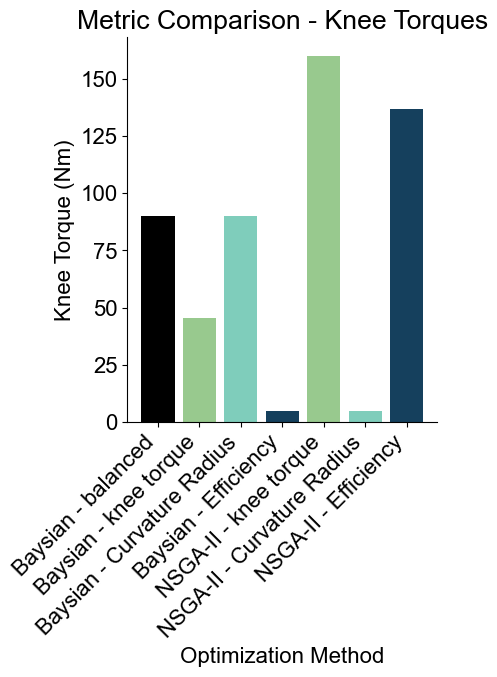

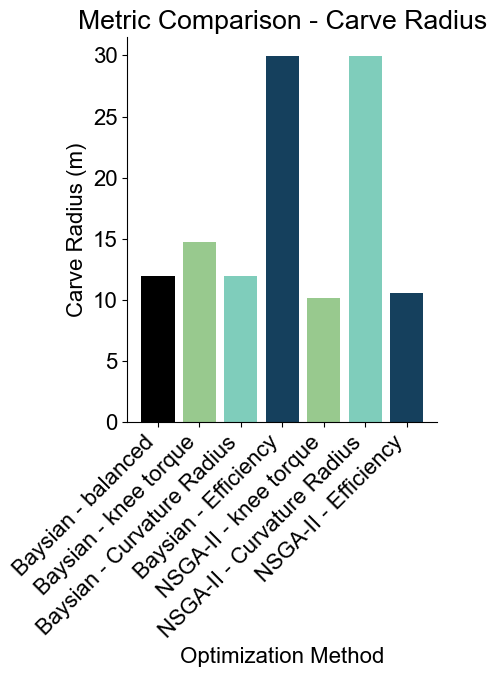

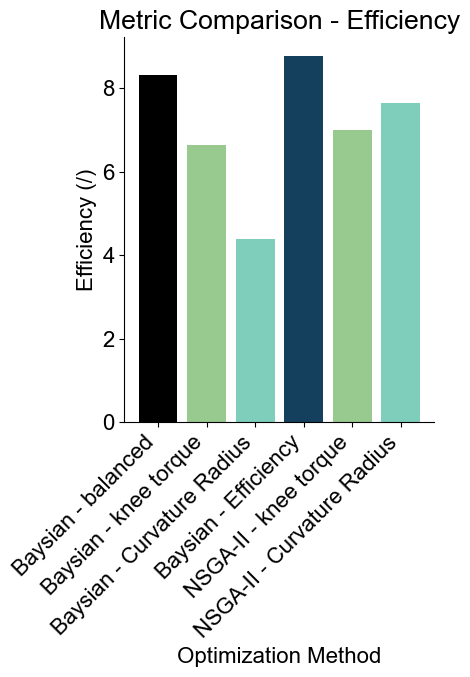

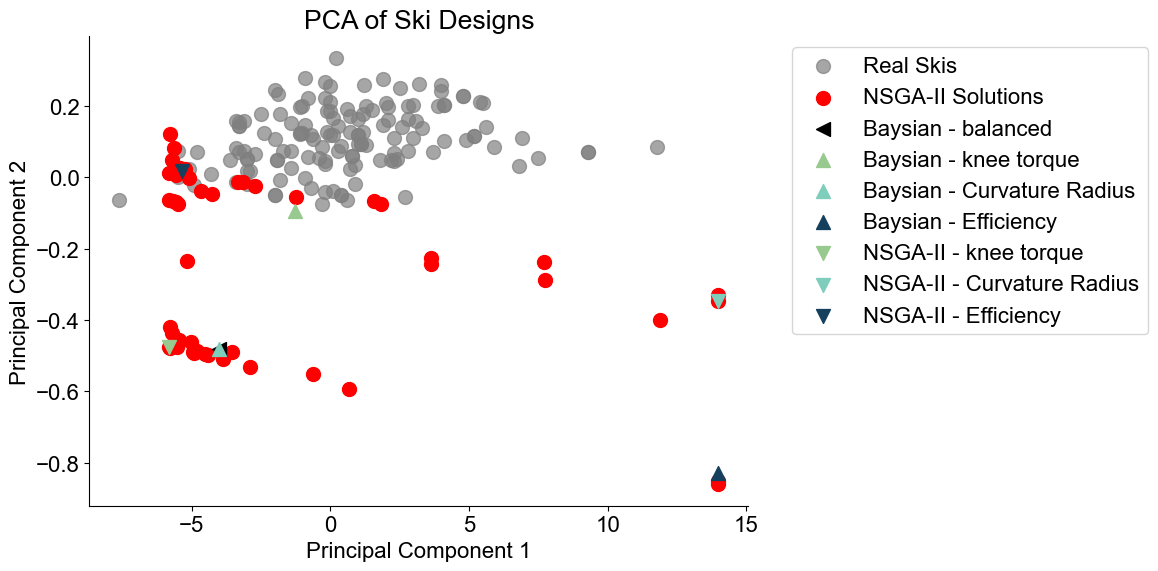

In [14]:
from sklearn.decomposition import PCA

vectorArray = np.vstack([skopt_all_vec, skopt_kneetau_vec, skopt_rcon_vec, skopt_eff_vec, nsga_knee_vec, nsga_rcon_vec, nsga_eff_vec])

l = vectorArray.shape[1]+1
tau = np.zeros((l))
r_cons = np.zeros((l))
effs = np.zeros((l))

for i in range(0,len(effs)):
    results = ski_turn_iterative(vectorArray[i,:], v_ski=9)
    r_cons[i] = results[3]
    tau[i] = results[4]
    effs[i] = results[5]

set_text(4,5)
#collect all of the results vectors and compare their performance
dataLabels = ["Baysian - balanced", "Baysian - knee torque", "Baysian - Curvature Radius", "Baysian - Efficiency", "NSGA-II - knee torque", "NSGA-II - Curvature Radius", "NSGA-II - Efficiency"]
color_opts = ['black',"#98c98e", '#7fcdbb', "#15405d","#98c98e", '#7fcdbb', '#15405d']
#color_opts = ['black', "#ffeda0", "#feb24c", "#f03b20", "#ffeda0", "#feb24c", "#f03b20"]
col = color_opts
#knee torques
PlotName = "Metric Comparison - Knee Torques"
plt.figure()
plt.title(PlotName)
plt.bar(dataLabels, tau, color = col)
plt.xlabel("Optimization Method")
plt.ylabel("Knee Torque (Nm)")
plt.xticks(rotation=45, ha='right') 
plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "Metric Comparison - Carve Radius"
plt.figure()
plt.title(PlotName)
plt.bar(dataLabels, r_cons, color = col)
plt.xlabel("Optimization Method")
plt.ylabel("Carve Radius (m)")
plt.xticks(rotation=45, ha='right') 
plt.savefig("Figures/" + PlotName + ".png", dpi=300)

PlotName = "Metric Comparison - Efficiency"
plt.figure()
plt.title(PlotName)
plt.bar(dataLabels, effs, color = col)
plt.xlabel("Optimization Method")
plt.ylabel("Efficiency (/)")
plt.xticks(rotation=45, ha='right') 
plt.savefig("Figures/" + PlotName + ".png", dpi=300)


#make PCA plot
set_text(8,8)
soothdata = importData()
all_data = np.vstack([vectorArray, pareto_solutions_X, soothdata])

print(f"Data shape (features x samples): {all_data.shape}")

# # --- Step 3: Run PCA on the array ---
# # sklearn expects shape (samples, features), so transpose back temporarily
pca = PCA(n_components=2)
principal_components = pca.fit_transform(all_data)

print("Explained variance ratio:", pca.explained_variance_ratio_)

# --- Step 4: Plot the first two principal components of the data ---
plt.figure(figsize=(12,6))
#plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.7, label="Data Samples")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Ski Designs")

# --- Step 5: Plot an additional feature vector on top as a star ---

# Plot original data
feature_vector_pca = pca.transform(soothdata)

plt.scatter(
    feature_vector_pca[:, 0],
    feature_vector_pca[:, 1],
    color='gray',
    marker='o',
    alpha = 0.7, 
    s=100,
    label='Real Skis'
)

#plot NSGA Pareto Front
feature_vector_pca = pca.transform(pareto_solutions_X)

plt.scatter(
    feature_vector_pca[:, 0],
    feature_vector_pca[:, 1],
    color='red',
    marker='o',
    s=100,
    label='NSGA-II Solutions'
)

#plot the individual
#plot each of the individual optimized points
feature_vector_pca = pca.transform(vectorArray)

shapes = ["<","^","^","^","v","v","v"]

for j in range(0,len(effs)):

    plt.scatter(
        feature_vector_pca[j, 0],
        feature_vector_pca[j, 1],
        color=color_opts[j],
        marker=shapes[j],
        s=100,
        label=dataLabels[j]
    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(False)

PlotName = "PCA Plot"
plt.savefig("Figures/" + PlotName + ".png", dpi=300)
plt.show()

C:\Users\laSch\AppData\Local\Temp\ipykernel_27312\3969229274.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datasubset[data_Strings[i]] = datasubset[data_Strings[i]]/scale_factors[i]
c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:232: RuntimeWarning: invalid value encountered in log10
  Efficiency = np.log10(-1/(F_f2/Fg))


(500, 9)


c:\Users\laSch\Desktop\Fall 2025\2.156\Final Project\Code\Ski-Optimization\Ski_Optimization_Simplified.py:195: RuntimeWarning: invalid value encountered in arcsin
  phi = np.arcsin(v_ski**2/g/r_sc)


(140, 9)


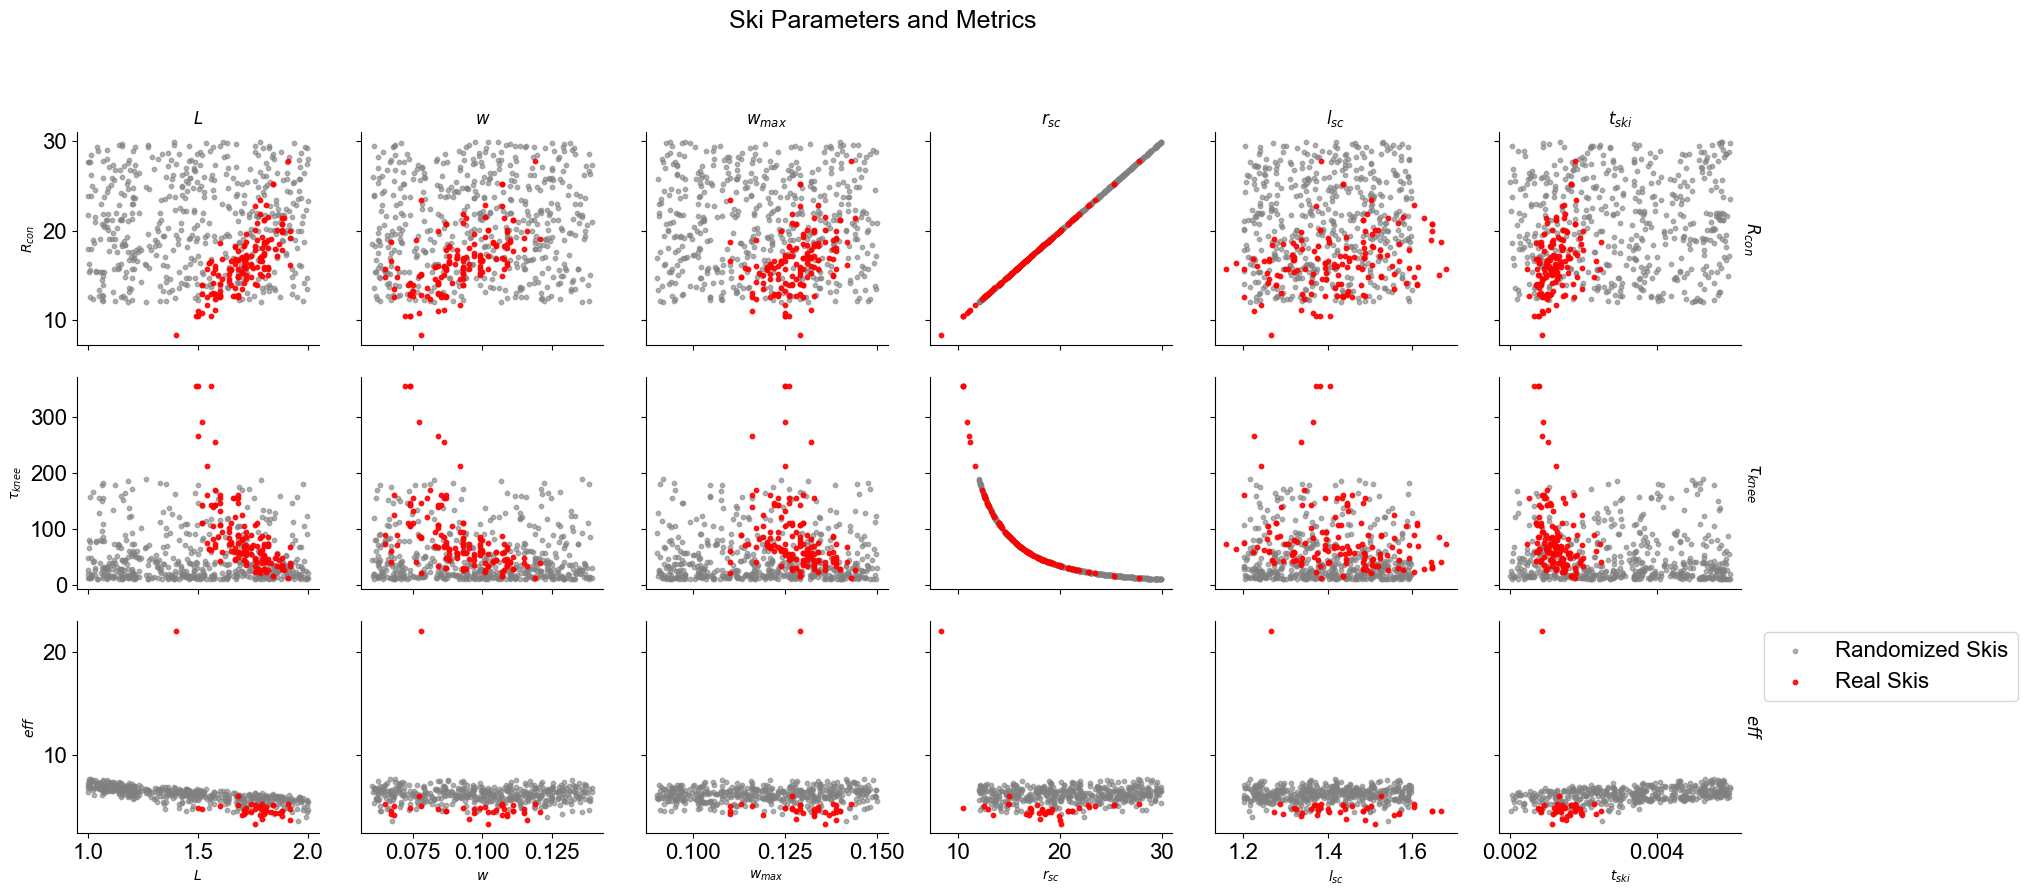

In [15]:
#copied code for comparing to randomized skis
# ------ Code to make plots ------------

# L = 2.0 #m, length of ski
# w = 0.099 #m, waist width
# w_max = .125 #m, max width
# r_sc = 17.3 #m, sidecut radius
# l_sc = 1.31 #length of sidecut
# t_ski = .005 #thickness of ski
# np.random.seed(42)
set_text(12,10)
Lbounds = [1,2]
wbounds = [0.06,0.14]
wmaxbounds = [.09,0.15]
r_scbounds = [12,30]
l_scbounds = [1.2,1.6]
t_skibounds = [0.002,0.005]

# print(np.random.uniform(Lbounds))

def gen_random_skis(N_samples):
    # generating random skis, and calculates metrics R_con, tau_knee, eff for all of them. 
    # returns np.array of size (N_samples, 9) where first 6 rows are the ski params, last 3 are the metrics

    N_samples = 500
    random_skis = []
    for i in range(N_samples):
        skivec = [np.random.uniform(*Lbounds), np.random.uniform(*wbounds), np.random.uniform(*wmaxbounds),np.random.uniform(*r_scbounds),np.random.uniform(*l_scbounds),np.random.uniform(*t_skibounds)]
        random_skis.append(skivec)

    random_skis = np.array(random_skis)

    # print('randomly generated skis', random_skis)
    #calculating metrics for all of the random skis
    skimetrics = []

    for ski in random_skis:
        s,h, Fs, R_con, tau_knee, eff = ski_turn_iterative(ski, v_ski = 10)
        metr = [R_con,tau_knee,eff]

        skimetrics.append(metr)

    ski_metrics = np.array(skimetrics)

    skis_and_metrics = np.concatenate((random_skis,ski_metrics),axis=1)
    print(skis_and_metrics.shape)

    return skis_and_metrics

def gen_data_skis(data):

    random_skis = data
    # print('randomly generated skis', random_skis)
    #calculating metrics for all of the random skis
    skimetrics = []

    for ski in random_skis:
        s,h, Fs, R_con, tau_knee, eff = ski_turn_iterative(ski, v_ski = 10)
        metr = [R_con,tau_knee,eff]

        skimetrics.append(metr)

    ski_metrics = np.array(skimetrics)

    skis_and_metrics = np.concatenate((random_skis,ski_metrics),axis=1)
    print(skis_and_metrics.shape)

    return skis_and_metrics


# format of each vector is [L,w,wmax,r_sc,l_sc,t_ski,R_con,tau_knee,eff]
data = importData()
skis_and_metrics = gen_random_skis(500)
skis_and_metrics_real = gen_data_skis(data)
# # def plot_relationships(skis_and_metrics):
# L = [ski[0] for ski in skis_and_metrics]
# w = [ski[1] for ski in skis_and_metrics]
# wmax = [ski[2] for ski in skis_and_metrics]
# r_sc = [ski[3] for ski in skis_and_metrics]
# l_sc =  [ski[4] for ski in skis_and_metrics]
# t_ski = [ski[5] for ski in skis_and_metrics]
# R_con = [ski[6] for ski in skis_and_metrics]
# tau_knee = [ski[7] for ski in skis_and_metrics]
# eff = [ski[8] for ski in skis_and_metrics]

# plt.title('Length and tau_knee')
# plt.xlabel('Ski length')
# plt.ylabel('Tau_knee')
# plt.scatter(L,tau_knee)
#import numpy as np
import matplotlib.pyplot as plt

# --- DATA ASSUMPTION ---
# The (500, 9) array 'skis_and_metrics' is assumed to be defined here.
# (Assuming your array is already loaded or defined elsewhere in your environment)
# -------------------------


# Define the column names
param_names = [r'$L$', r'$w$', r'$w_{max}$', r'$r_{sc}$', r'$l_{sc}$', r'$t_{ski}$']
metric_names = [r'$R_{con}$', r'$\tau_{knee}$', r'$eff$']

N_metrics = len(metric_names)   # 3 rows (for Y-axis metrics)
N_params = len(param_names)     # 6 columns (for X-axis parameters)

# --- 1. CREATE SUBPLOTS ---
# Create a figure with 3 rows (Metrics) and 6 columns (Parameters)
fig, axes = plt.subplots(N_metrics, N_params, figsize=(18, 9), sharex='col', sharey='row')
fig.suptitle('Ski Parameters and Metrics ', fontsize=18, y=1.03)

# --- 2. GENERATE PLOTS IN A NESTED LOOP ---
# row_idx: Metric index (0 to 2) -> defines the Y-axis data
# col_idx: Parameter index (0 to 5) -> defines the X-axis data

for row_idx in range(N_metrics):
    for col_idx in range(N_params):
        
        # Metric index in the (500, 9) array starts at 6
        m_idx_data = 6 + row_idx  # Used for Y-Axis data (Metric)
        p_idx_data = col_idx      # Used for X-Axis data (Parameter)
        
        # Select the correct Axes object: axes[row, column]
        ax = axes[row_idx, col_idx]
        
        # X-Axis Data: Parameter (columns 0-5)
        X_data = skis_and_metrics[:, p_idx_data] 
        # Y-Axis Data: Metric (columns 6-8)
        Y_data = skis_and_metrics[:, m_idx_data] 
        
        # Create the Scatter Plot
        ax.scatter(X_data, Y_data, s=10, alpha=0.6, color='gray')

        #now overlay the real data too
        X_real = skis_and_metrics_real[:,p_idx_data]
        Y_real = skis_and_metrics_real[:, m_idx_data]
        ax.scatter(X_real, Y_real, s=10, alpha=0.9, color='red')
        #ax.legend(['Randomized Skis', 'Real Skis'])
        
        # --- Labeling Logic ---
        
        # X-Axis Labels (Parameter name): Only set for the bottom row (row_idx == N_metrics - 1)
        if row_idx == N_metrics - 1:
            ax.set_xlabel(param_names[col_idx], fontsize=10) # Use the Parameter name for X-label
        
        # Y-Axis Labels (Metric name): Only set for the first column (col_idx == 0)
        if col_idx == 0:
            ax.set_ylabel(metric_names[row_idx], fontsize=10) # Use the Metric name for Y-label
        
        # Column Titles: Add Parameter name as a title (for the top row)
        if row_idx == 0:
            ax.set_title(param_names[col_idx], fontsize=12)

        # Row Labels: Add Metric name as a label on the right side of the figure
        if col_idx == N_params - 1:
            ax.yaxis.set_label_position("right")
            ax.set_ylabel(metric_names[row_idx], rotation=270, labelpad=15, fontsize=12)


# --- 3. FINAL LAYOUT ADJUSTMENTS ---
# Adjust spacing between subplots

fig.tight_layout(rect=[0, 0.03, 1, 1.00]) 
plt.legend(['Randomized Skis', 'Real Skis'], bbox_to_anchor=(1.05, 1), loc='upper left')
PlotName = "Value Comparison"
plt.savefig("Figures/" + PlotName + ".png", dpi=300)



OLD NSGA-II from mid progress report

In [16]:
#Trying to implement optimization - NSGA-II Old attempt

# pymoo imports
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.termination import get_termination

from pymoo.core.callback import Callback
from tqdm import tqdm

class ProgressBarCallback(Callback):
    def __init__(self, total_generations):
        super().__init__()
        self.total_generations = total_generations
        self.pbar = tqdm(total=total_generations, desc="NSGA-II Progress")

    def notify(self, algorithm):
        self.pbar.update(1)

    def finalize(self):
        self.pbar.close()

# L = 2.0 #m, length of ski
# w = 0.099 #m, waist width
# w_max = .125 #m, max width
# r_sc = 17.3 #m, sidecut radius
# l_sc = 1.31 #length of sidecut
#t_ski = .005 #thickness of ski
# --- Define the multi-objective problem ---
class SkiTurnProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=5,                # number of input parameters
            n_obj=2,                # eff and sens
            n_constr=2,             # no constraints for now
            xl=np.array([1,0.06,.09,8,1.2,0.002]),  # lower bounds for [L, w, w_max, r_sc, l_sc,t_ski]
            xu=np.array([2,0.14,0.15,30,1.6,0.01])   # upper bounds for each parameter (adjust!)
        )

    def _evaluate(self, x, out, *args, **kwargs):
        # Call your ski_turn_iterative function
        s,h, Fs, R_con, tau_knee, eff = ski_turn_iterative(x)
        
        # Set objectives
        out["F"] = np.array([eff, tau_knee], dtype=float)
        
        # Set constraints (must be <= 0)
        # x = [L, w, w_max, r_sc, l_sc]
        L, w, w_max, r_sc, l_sc, t_ski = x
        g1 = w - w_max          # w <= w_max
        g2 = l_sc - L   # l_sc <= L
        out["G"] = np.array([g1, g2], dtype=float)

# --- Set up NSGA-II algorithm ---
algorithm = NSGA2(
    pop_size=50,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=0.2, eta=20)
)

gens = 20
# --- Termination criterion ---
# from pymoo.factory import get_termination
termination = get_termination("n_gen", gens)

#making a progress bar
# progress_cb = ProgressBarCallback(total_generations=gens)

import sys
import os

# Suppress prints
old_stdout = sys.stdout
sys.stdout = open(os.devnull, "w")

# --- Run optimization ---
results = minimize(
    SkiTurnProblem(),
    algorithm,
    termination,
    seed=1,
    verbose=False,
    callback=ProgressBarCallback(total_generations=gens)
)

# Restore prints
sys.stdout.close()
sys.stdout = old_stdout

# --- Inspect results ---
print("Pareto-optimal decision variables")
print(results.X)
print("Corresponding objective values [eff, sens]:")
print(results.F)



NSGA-II Progress:   0%|          | 0/20 [00:00<?, ?it/s]

ValueError: operands could not be broadcast together with shapes (6,) (50,5) 

-0.9999999999800946


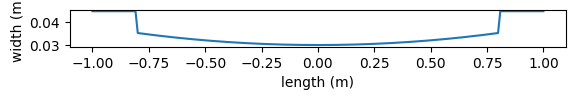

In [ ]:
#visualize the optimized ski 
L, w, w_max, r_sc, l_sc = results.X[0]
s_vis = np.linspace(-L/2, L/2, 200)
print(s_vis[0])
widths = get_widths(s_vis, L, w, w_max, r_sc, l_sc)
plot_ski(s_vis,widths)

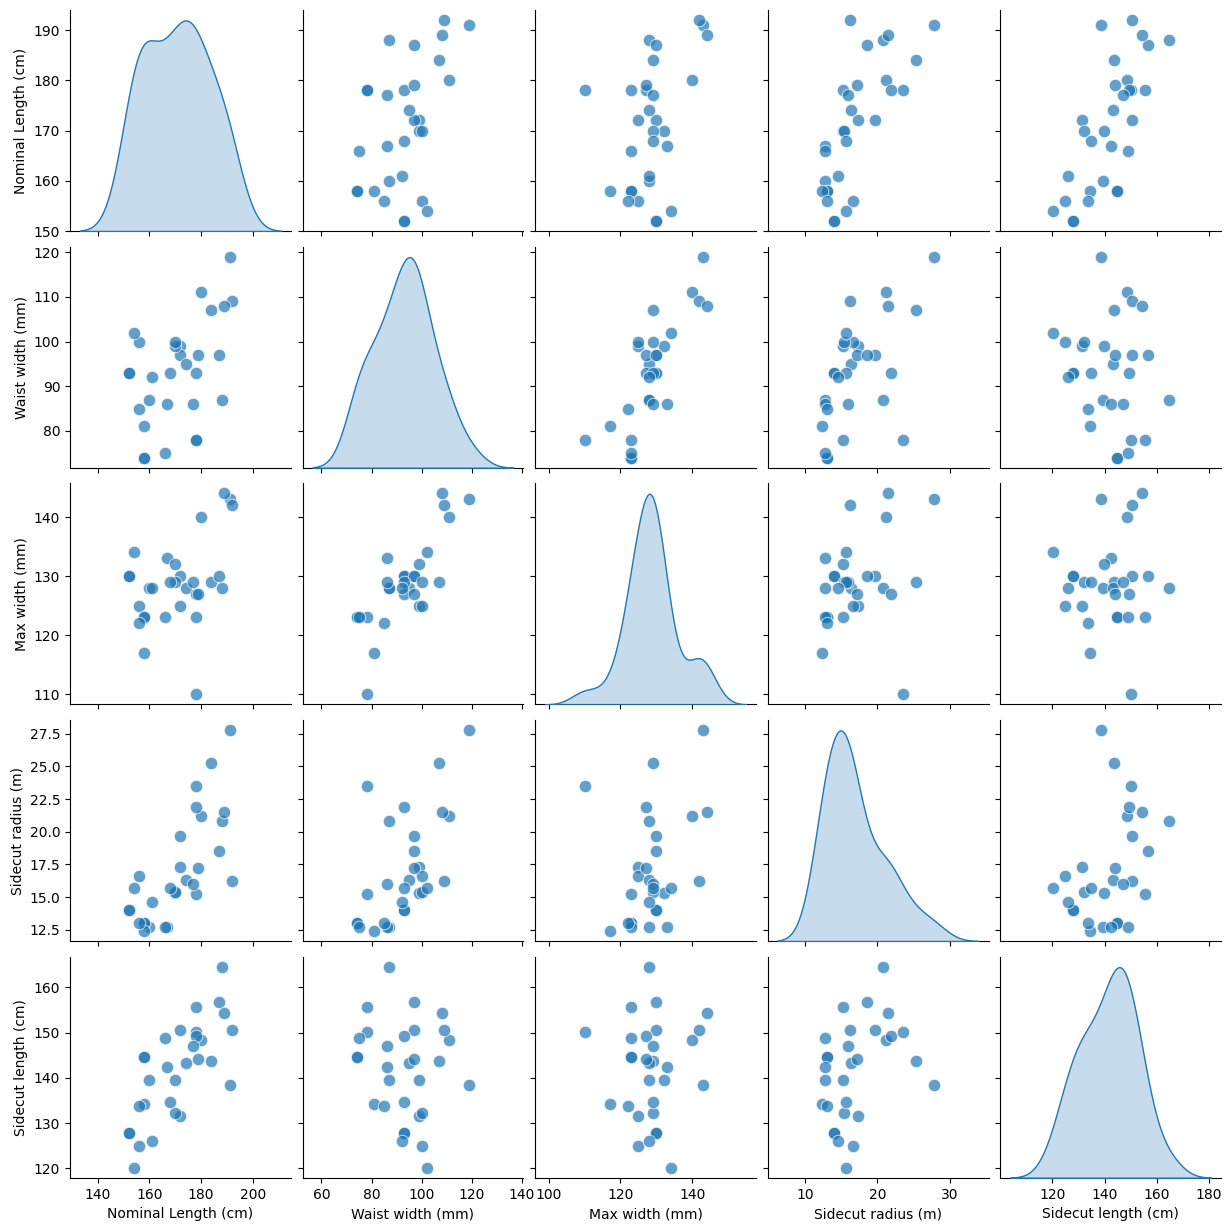

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Lstring = "191	172	184	188	152	172	156	160	152	158	178	180	174	158	178	167	179	178	170	158	192	187	166	170	177	154	189	168	161	156"
wstring = "119	99	107	87	93	97	100	87	93	74	78	111	95	74	93	86	97	78	99	81	109	97	75	100	86	102	108	93	92	85"
wmaxstring = "143	125	129	128	130	130	125	128	130	123	110	140	128	123	127	133	127	123	132	117	142	130	123	129	129	134	144	129	128	122"
rscstring = "27.8 17.3	25.3	20.8	14	19.7	16.6	12.7	14	13	23.5	21.2	16.3	13	21.9	12.7	17.2	15.2	15.3	12.4	16.2	18.5	12.7	15.4	16	15.7	21.5	15.7	14.6	13"
lscstring = "138.5	131.5	143.6	164.6	127.8	150.5	125	139.4	127.8	144.6	150.2	148.4	143.3	144.6	149.3	142.3	144.1	155.6	139.6	134.3	150.5	156.8	148.9	132.1	147.1	120.1	154.3	134.6	126	133.8"

SS_L = [float(x) for x in Lstring.split()]
SS_w = [float(x) for x in wstring.split()]
SS_w_max = [float(x) for x in wmaxstring.split()]
SS_r_sc = [float(x) for x in rscstring.split()]
SS_L_sc = [float(x) for x in lscstring.split()]

data = {
    "Nominal Length (cm)": SS_L,
    "Waist width (mm)": SS_w,
    "Max width (mm)": SS_w_max,
    "Sidecut radius (m)": SS_r_sc,
    "Sidecut length (cm)": SS_L_sc,
}

df = pd.DataFrame(data)

sns.pairplot(df, diag_kind="kde", plot_kws={'alpha':0.7, 's':80})
# plt.title("True Skis on the Market from SoothSki Website")
plt.xlabel("X Axis Label", fontsize=18)
plt.ylabel("Y Axis Label", fontsize=18)
plt.show()


Available parameters: ['nominal length (cm)', 'length (cm)', 'running length (cm)', 'nan', 'sidecut length (cm)', 'nan', 'sidecut', 'tip width (mm)', 'waist width (mm)', 'tail width (mm)', 'sidecut radius (m)', 'mass & float', 'weight (g)', 'surface-to-weight ratio (cm²/g)', 'base area (cm²)', 'stiffnesses', 'bending (ei) stiffness index', 'torsional (gj) stiffness index', 'average bending stiffness - ei (nm²)', 'average torsional stiffness - gj (nm²)', 'rockers', 'tip height (mm)', 'tip rocker length (mm)', 'tail height (mm)', 'tail rocker length (mm)', 'shapes', 'tip taper length (mm)', 'tail taper length (mm)', 'tip engagement (mm)', 'camber (mm)', 'setback (cm)', 'taper angle (°)']
Using columns: ['nominal length (cm)', 'sidecut length (cm)', 'tip width (mm)', 'waist width (mm)', 'sidecut radius (m)']


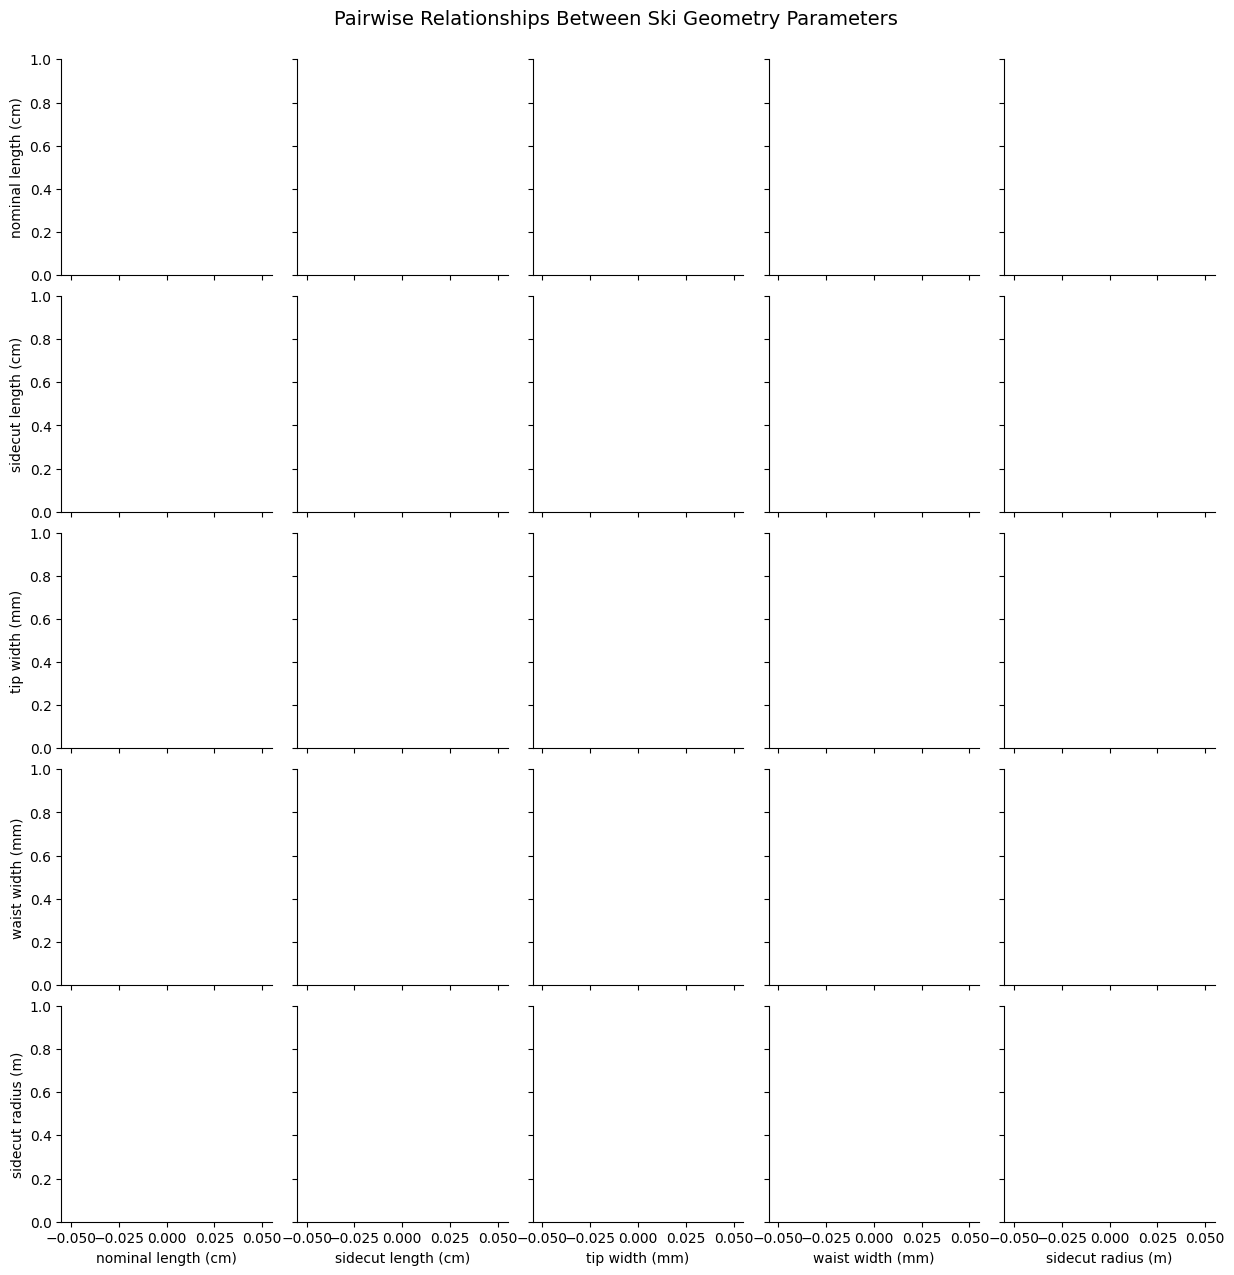

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

